# Transfer learning with a pretrained ConvNet

Lets try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. Simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.
We will not (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

General machine learning workflow:

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
keras = tf.keras


#warnings.filterwarnings('ignore')
#logging.getLogger("tensorflow").setLevel(logging.ERROR)


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
print("TF version:", tf.__version__)

TF version: 2.0.0


In [5]:
import IPython.display as display
from PIL import Image


In [6]:
from datetime import datetime
#from keras.preprocessing import image
#from PIL import Image
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split
# from sklearn.calibration import calibration_curve
#from tensorflow.keras import layers

tf.__version__

'2.0.0'

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [7]:
import pathlib
data_dir = 'data'
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available.

The directory contains 5 sub-directories, one per class:

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

34278

In [9]:
print(os.getcwd())
data_dir

/home/ec2-user/Projects/zappos-MobileNetV2-tranfer


PosixPath('data')

In [10]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['Boots', 'Shoes', 'Sneakers'], dtype='<U8')

Each directory contains images of that type of flower. Here are some roses:

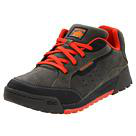

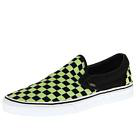

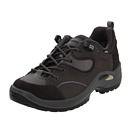

In [11]:
sneakers = list(data_dir.glob('Sneakers/*'))

for image_path in sneakers[:3]:
    display.display(Image.open(str(image_path)))

## Load using `tf.data`

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [12]:
BATCH_SIZE = 128
IMG_SIZE = 224 # All images will be resized to 224x224
CHANNELS = 3
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

SEED = 666777



In [13]:
train_dir = 'train'
train_dir = pathlib.Path(train_dir)

val_dir = 'validate'
val_dir = pathlib.Path(val_dir)

test_dir = 'test'
test_dir = pathlib.Path(test_dir)
train_list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'),shuffle=True,seed=SEED)
validate_list_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'),shuffle=True,seed=SEED)
test_list_ds = tf.data.Dataset.list_files(str(test_dir/'*/*'),shuffle=True,seed=SEED)

In [14]:
for f in validate_list_ds.take(5):
  print(f.numpy())

b'validate/Boots/7543660.239864.jpg'
b'validate/Shoes/7794342.358542.jpg'
b'validate/Sneakers/7887584.1001.jpg'
b'validate/Sneakers/7901787.357827.jpg'
b'validate/Sneakers/8044476.911.jpg'


Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [15]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  #out=parts.one_hot(CLASS_NAMES, 3) 
  return parts[-2] == CLASS_NAMES

In [16]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [17]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    img = tf.io.read_file(filename)
    image_decoded = decode_img(img)
    image_normalized = image_decoded / 255.0
    #     label = label
    return image_normalized, label


In [19]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    return parse_function(file_path, label)
#   img = tf.io.read_file(file_path)
#   #img = decode_img(img)
#   #img = (img/127.5) - 1  # center values
#   return img, label

In [20]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0])
      plt.axis('off')

In [18]:
#conversion to ints this way:
(CLASS_NAMES == CLASS_NAMES[1])*1


array([0, 1, 0])

Use `Dataset.map` to create a dataset of `image, label` pairs:


## Data preprocessing

The resulting `tf.data.Dataset` objects contain `(image, label)` pairs where the images have variable shape and 3 channels, and the label is a scalar.

print(train_ds)
Show the first two images and labels from the training set:

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

### Basic methods for training

In [21]:
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
#SHUFFLE_BUFFER_SIZE = 1000



To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [22]:
train = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
validation = validate_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [23]:
train = train.cache()
train_batches = train.batch(BATCH_SIZE)
train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)

In [24]:
    
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Apply this function to each item in the dataset using the map method:
This will also shuffle and batch

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [25]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
print(IMG_SHAPE)

(224, 224, 3)


In [26]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') #pooling = 'avg'

This feature extractor converts each `224x224x3` image into a `7x7x1280` block of features. See what it does to the example batch of images:

In [27]:
train_batches.take(1)

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.bool)>

In [33]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([128, 224, 224, 3])

In [34]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 7, 7, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [35]:
base_model.trainable = False

In [36]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [33]:
N_LABELS = CLASS_NAMES.shape[0]

Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
hidden_layer         = tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer')
prediction_layer     = tf.keras.layers.Dense(N_LABELS, activation='sigmoid', name='output')


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  hidden_layer,
  prediction_layer
])

# model = tf.keras.Sequential([
#     base_model,
#     global_average_layer,  # this is to make sure the output 
#     tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
#     tf.keras.layers.Dense(N_LABELS, activation='sigmoid', name='output')
# ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 3)                 3075      
Total params: 3,572,803
Trainable params: 3,538,691
Non-trainable params: 34,112
_________________________________________________________________


In [39]:
# definethe batch F1 to measure performance... might not have big enough batch sizes for this....
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [40]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        model = tf.keras.Sequential([
#   base_model,
#   global_average_layer,
#   prediction_layer
# ])
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

### Compile the model

You must compile the model before training it.  Since there are three classes, lets use KL divergence `kullback_leibler_divergence`... if we move on to variational autoencoders we'll definatley want this

In [41]:
#base_learning_rate = 0.001
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#              loss = tf.keras.losses.kullback_leibler_divergence,#loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])

# model.compile(
#   optimizer=tf.keras.optimizers.Adam(),
#   loss='categorical_crossentropy',
#   metrics=['acc'])


In [41]:
#start = time()
history = model.fit(train_batches,
                    epochs=EPOCHS)
#print('\nTraining took {}'.format(print_time(time()-start)))

NameError: name 'EPOCHS' is not defined

In [51]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, keras.metrics.mae, keras.metrics.categorical_accuracy]
    #loss=macro_soft_f1,
)

In [52]:
from time import time
start = time()
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/30
211/211 [==============================] - 177s 841ms/step - loss: 0.2717 - macro_f1: 0.7996 - mean_absolute_error: 0.1989 - categorical_accuracy: 0.8562 - val_loss: 0.0000e+00 - val_macro_f1: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/30
211/211 [==============================] - 168s 796ms/step - loss: 0.1186 - macro_f1: 0.9308 - mean_absolute_error: 0.0748 - categorical_accuracy: 0.9341 - val_loss: 0.7648 - val_macro_f1: 0.0000e+00 - val_mean_absolute_error: 0.4129 - val_categorical_accuracy: 0.2997
Epoch 3/30
211/211 [==============================] - 170s 806ms/step - loss: 0.0930 - macro_f1: 0.9458 - mean_absolute_error: 0.0572 - categorical_accuracy: 0.9483 - val_loss: 0.8103 - val_macro_f1: 0.0000e+00 - val_mean_absolute_error: 0.3973 - val_categorical_accuracy: 0.2997
Epoch 4/30
211/211 [==============================] - 170s 806ms/step - loss: 0.0767 - macro_f1: 0.9556 - mean_absolute_error: 0.0476 - categorical_

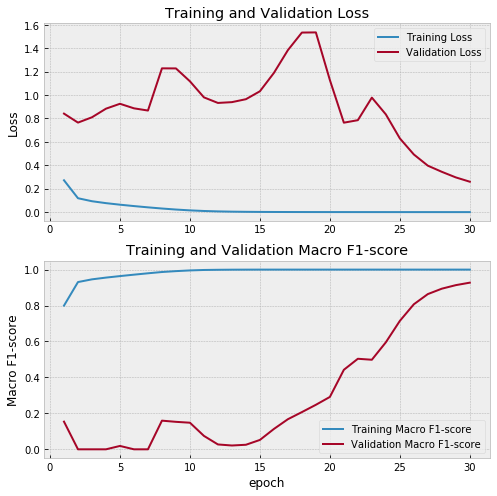

In [53]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

# loss=tf.keras.metrics.binary_crossentropy,
#    metrics=[macro_f1, keras.metrics.mae, keras.metrics.categorical_accuracy,macro_soft_f1]

In [57]:
history.history['categorical_accuracy']

[0.8561944,
 0.93405044,
 0.94829375,
 0.9578635,
 0.966951,
 0.9740727,
 0.98112017,
 0.9879451,
 0.9929525,
 0.99643916,
 0.9981825,
 0.9991469,
 0.9997033,
 0.9999258,
 0.9999629,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [58]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.26
Macro F1-score: 0.93


In [60]:
# Save the model
model.save('transfer_model.h5',save_format='h5')
print("Saved model to disk")
# Save the model
model.save('transfer_model.tf',save_format='tf')
print("Saved model to disk")

Saved model to disk
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: transfer_model.tf/assets
Saved model to disk


In [56]:
# # Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model.h5')
import pickle
with open('text3', 'wb') as f:
    pickle.dump(history.history, f)
print(f'pickled history as text3')
    
# could also JSON or just save weights
# serialize model to JSON
model_json = model.to_json()
with open("transfer_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("transfer_model_weights.h5")
#print("Saved model WEIGHTS to disk")

TypeError: save() got an unexpected keyword argument 'format'

# start here if we've already trained the initial epochs

In [50]:
# Recreate the exact same model purely from the file
#model = keras.models.load_model('path_to_my_model.h5')
# because we ahve a custom loss / metric function we need to do this


model = keras.models.load_model('path_to_my_model.h5', custom_objects={'macro_f1': macro_f1})
# model.save("model/", save_format='tf')
# new_model = keras.models.load_model('model/', custom_objects={'score': CustomMetric()},compile=False)

if False:
    modelFile = 'path_to_my_model.h5'

    model = keras.models.model_from_json(open(modelFile).read())
    model.load_weights(os.path.join(os.path.dirname(modelFile), 'path_to_my_model.h5'))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [50]:
# load json and create model
json_file = open('transfer_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model = %load_ex("transfer_model_weights.h5")
print("Loaded model from disk")
model.load_weights("transfer_model_weights.h5")
print("Loaded model weights from disk")

In [62]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


ValueError: too many values to unpack (expected 2)

In [61]:
test_batches.unbatch()

y_pred=model.predict_classes(test_images.)
model.predict_classes()

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

SyntaxError: invalid syntax (<ipython-input-61-a4f1472927ae>, line 3)

Normalization Confusion Matrix to the interpretation of which class is being misclassified.

In [50]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)


In [ ]:
initial_epochs = 10
validation_steps=20



model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, metrics.mae, metrics.categorical_accuracy]
)

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [42]:
#########################utilities that should just be set up as a module
import os
import shutil
import urllib.error
import urllib.request

import matplotlib.pyplot as plt
import matplotlib.style as style
import multiprocessing

import numpy as np
import pandas as pd
import tensorflow as tf

from joblib import Parallel, delayed
from time import time
#from tqdm import tqdm


def download_parallel(movies, image_dir):
    """Downloads images from Internet in parallel.
    
    Args:
        movies (dataframe): must contain 'imdbId' and 'Poster' url columns
        image_dir (string): path to destination directory
    
    Returns:
        movies (dataframe): input dataframe without posters that failed to download
    """
    
    # Create list of filenames
    filenames = movies['imdbId'].apply(lambda imbdId : os.path.join(image_dir, str(imbdId)+'.jpg'))
    # Create list of image urls
    urls = movies['Poster']

    # Create destination directory
    if os.path.exists(image_dir):
        print("Directory '{}' already exists and will be deleted.".format(image_dir))
        shutil.rmtree(image_dir)
    print("Created new directory '{}'".format(image_dir))
    os.makedirs(image_dir)
    
    # Define function to download one single image
    def download_image(url, filename):
        try:
            urllib.request.urlretrieve(url, filename)
            return 0
        except:
            return os.path.basename(filename).split('.')[0]
    
    # Download images in parallel
    start = time()
    print("\nDownloading...")
    num_cores = multiprocessing.cpu_count()
    ko_list = Parallel(n_jobs=num_cores)(delayed(download_image)(u, f) for f, u in zip(filenames, urls))
    
    print("\nDownload in parallel mode took %d seconds." %(time()-start))
    print("Success:", len([i for i in ko_list if i==0]))
    print("Errors:", len([i for i in ko_list if i!=0]))
    
    # Remove not downloaded posters from the dataframe
    ko_index = movies[movies['imdbId'].isin(ko_list)].index
    movies = movies.drop(ko_index)
    
    return movies
    

def download_sequential(movies, image_dir):
    """Downloads images from Internet sequentially.
    
    Args:
        movies (dataframe): must contain 'imdbId' and 'Poster' columns
        image_dir (string): path to destination directory
        
    Returns:
        movies (dataframe): input dataframe without posters that failed to download
    """
    
    # Create list of filenames
    filenames = movies['imdbId'].apply(lambda imbdId : os.path.join(image_dir, str(imbdId)+'.jpg'))
    # Create list of image urls
    urls = movies['Poster']

    # Create destination directory
    if os.path.exists(image_dir):
        print("Directory '{}' already exists and will be deleted.".format(image_dir))
        shutil.rmtree(image_dir)
    print("Created new directory '{}'".format(image_dir))
    os.makedirs(image_dir)
    
    # Define function to download one single image
    def download_image(image_path, filename):
        urllib.request.urlretrieve(image_path, filename)
    
    # Download images sequentially
    start = time()
    print("\nDownloading...")
    ko_list = []
    for i in tqdm(range(len(filenames))):
        filename = filenames.iloc[i]
        url = urls.iloc[i]
        try:
            download_image(url, filename)
        except:
            img_id = os.path.basename(filename).split('.')[0]
            ko_list.append(img_id)
            pass
    
    print("\nDownload in sequential mode took %d seconds." %(time()-start))
    print("Success:", (len(filenames)-len(ko_list)))
    print("Errors:", len(ko_list))
    
    # Remove not downloaded posters from the dataframe
    ko_index = movies[movies['imdbId'].isin(ko_list)].index
    movies = movies.drop(ko_index)
    
    return movies


def micro_bce(y, y_hat):
    """Compute the micro binary cross-entropy on a batch of observations.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)      
        y_hat (float32 Tensor): probability matrix output from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    # Convert the target array to float32
    y = tf.cast(y, tf.float32)
    # Implement cross entropy loss for each observation and label
    cross_entropy = - y * tf.math.log(tf.maximum(y_hat, 1e-16)) - (1-y) * tf.math.log(tf.maximum(1-y_hat, 1e-16))
    # Average binary cross entropy across all batch observations and labels
    cost = tf.reduce_mean(cross_entropy)
    return cost


def macro_bce(y, y_hat):
    """Compute the macro binary cross-entropy on a batch of observations (average across all labels).
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)      
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    # Convert the target array to float32
    y = tf.cast(y, tf.float32)
    # Implement cross entropy loss for each observation and label
    cross_entropy = - y * tf.math.log(tf.maximum(y_hat, 1e-16)) - (1-y) * tf.math.log(tf.maximum(1-y_hat, 1e-16))
    # Average all binary cross entropy losses over the whole batch for each label
    cost = tf.reduce_mean(cross_entropy, axis=0)
    # Average all binary cross entropy losses over labels within the batch
    cost = tf.reduce_mean(cost)
    return cost


def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost


def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    
    #loss=tf.keras.metrics.binary_crossentropy,
    #metrics=[macro_f1, keras.metrics.mae, keras.metrics.categorical_accuracy,macro_soft_f1]

    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1


def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid


def print_time(t):
    """Function that converts time period in seconds into %h:%m:%s expression.
    Args:
        t (int): time period in seconds
    Returns:
        s (string): time period formatted
    """
    h = t//3600
    m = (t%3600)//60
    s = (t%3600)%60
    return '%dh:%dm:%ds'%(h,m,s)


### Train the model

After training for 10 epochs, you should see ~96% accuracy.


In [63]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

NameError: name 'loss0' is not defined

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)



In [ ]:
history.history['macro_f1']

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#kullback_leibler_divergence

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

    
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])


plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [ ]:
validation = prepare_for_training2(validate_labeled_ds,is_training=False) #, cache="./shoestest.tfcache")
test       = prepare_for_training2(test_labeled_ds,is_training=False) #, cache="./shoestest.tfcache")


for image_batch, label_batch in train.take(1):
    pass

image_batch.shape

for image_batch, label_batch in test.take(1):
    pass

image_batch.shape

In [ ]:
model.summary()

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

### Train the model

After training for 10 epochs, you should see ~96% accuracy.


In [64]:
initial_epochs = 10

validation_steps=20

loss0,accuracy0 = model.evaluate(validation, steps = validation_steps)

 1/20 [>.............................] - ETA: 0s

ValueError: Error when checking input: expected mobilenetv2_1.00_224_input to have 4 dimensions, but got array with shape (224, 224, 3)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train,
                    epochs=initial_epochs,
                    validation_data=validation,
                    validation_steps = validation_steps,
                    steps_per_epoch=STEPS_PER_EPOCH)

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
loss

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,.3])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100
200
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Compile the model

Compile the model using a much lower learning rate.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation)

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.


In [ ]:
### CROSS VALIDATION WOULD BE KEWL.... 

from sklearn.model_selection import KFold

# Parameters
learning_rate = 0.01
batch_size = 500

train_x_all = mnist.train.images
train_y_all = mnist.train.labels
test_x = mnist.test.images
test_y = mnist.test.labels

def run_train(session, train_x, train_y):
  print "\nStart training"
  session.run(init)
  for epoch in range(10):
    total_batch = int(train_x.shape[0] / batch_size)
    for i in range(total_batch):
      batch_x = train_x[i*batch_size:(i+1)*batch_size]
      batch_y = train_y[i*batch_size:(i+1)*batch_size]
      _, c = session.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
      if i % 50 == 0:
        print "Epoch #%d step=%d cost=%f" % (epoch, i, c)


def cross_validate(session, split_size=5):
  results = []
  kf = KFold(n_splits=split_size)
  for train_idx, val_idx in kf.split(train_x_all, train_y_all):
    train_x = train_x_all[train_idx]
    train_y = train_y_all[train_idx]
    val_x = train_x_all[val_idx]
    val_y = train_y_all[val_idx]
    run_train(session, train_x, train_y)
    results.append(session.run(accuracy, feed_dict={x: val_x, y: val_y}))

  return results

with tf.Session() as session:
  result = cross_validate(session)
  print "Cross-validation result: %s" % result
  print "Test accuracy: %f" % session.run(accuracy, feed_dict={x: test_x, y: test_y})



## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [ ]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_dir = 'train'
train_dir = pathlib.Path(train_dir)

test_dir = 'test'
test_dir = pathlib.Path(test_dir)


In [ ]:
train_data_gen = image_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     c200lasses = list(CLASS_NAMES))

In [ ]:
test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Inspect a batch:

In [ ]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.